### Census Trade Data

September 30, 2020

Brian Dew

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
# Retrieve data from Census API
d = {}
for flow in ['imports', 'exports']:
    base = f'https://api.census.gov/data/timeseries/intltrade/{flow}/hs'
    params = ['CTY_CODE', 'CTY_NAME', 'ALL_VAL_MO']
    if flow == 'imports':
        params[2] = 'GEN_VAL_MO'
    param = ','.join(params)
    url = f'{base}?get={param}&key={census_key}&time=from+1992-01'
    d[flow] = requests.get(url).json()

In [3]:
i = d['imports']
df = pd.DataFrame(i[1:], columns=i[0])
df = df[(df['CTY_CODE'].str[0] !='0') & 
        (df['CTY_CODE'].str[1] != 'X')]
df['Name'] = df['CTY_NAME'].str.title()
df['Date'] = pd.to_datetime(df['time'], format='%Y-%m')
imp = (df.rename({'GEN_VAL_MO': 'Imports'}, axis=1)
         .set_index(['Name', 'Date']).Imports.astype(float))

e = d['exports']
df = pd.DataFrame(e[1:], columns=e[0])
df = df[(df['CTY_CODE'].str[0] !='0') & 
        (df['CTY_CODE'].str[1] != 'X')]
df['Name'] = df['CTY_NAME'].str.title()
df['Date'] = pd.to_datetime(df['time'], format='%Y-%m')
exp = (df.rename({'ALL_VAL_MO': 'Exports'}, axis=1)
         .set_index(['Name', 'Date']).Exports.astype(float))

data = ((pd.DataFrame([imp, exp]).T / 1000000)
           .rename({'Korea, South': 'South Korea',
                    'Total For All Countries': 'Total, All Countries'}))

data.to_csv(data_dir / 'trade_master.csv')

data['Total'] = data['Imports'] + data['Exports']

dt = data.xs('Canada').index[-1]
ltdate = dtxt(dt)['mon1']
index = data.xs(dt, level=1).Total.sort_values(ascending=False).iloc[:26].index

final = data.loc[(index, dt),:].astype(int).droplevel('Date')
dt2 = dt - pd.DateOffset(months = 12)
data2 = data.loc[(index, dt2),:].astype(int).droplevel('Date')
data2.columns = [f'{k} ' for k in final.keys()]
final = final.join(data2).sort_values('Total', ascending=False)
final.index.name = ''

(final.applymap('{:,.0f}'.format)
      .to_csv(data_dir / 'trade_partner.tex', sep='&', 
              line_terminator='\\\ ', quotechar=' '))

write_txt(text_dir / 'trade_date.txt', dtxt(dt)['mon1'])
write_txt(text_dir / 'trade_date2.txt', dtxt(dt2)['mon1'])

shval = (final['Total '].iloc[1:].sum() / 
         final['Total '].iloc[0]) * 100
text = (f'In {ltdate}, trade with the top 25 trading partners (see table) '+
        f'comprises {shval:.1f} percent of total US trade in goods.')
write_txt(text_dir / 'trade_partner_sh.txt', text)
print(text)

In December 2021, trade with the top 25 trading partners (see table) comprises 86.8 percent of total US trade in goods.


### Trade Levels, Latest in Detail

In [4]:
result = pd.DataFrame()
url0 = 'https://www.census.gov/econ/currentdata/export/csv'
url1 = ('?programCode=FTD&timeSlotType=12&startYear=2015&'+
        'endYear=2022&categoryCode=BOPGS&')
for flow in ['EXP', 'IMP']:
    url2 = (f'dataTypeCode={flow}&geoLevelCode=US&adjusted=yes&'+
            'errorData=no&internal=false')
    url = url0 + url1 + url2
    s = pd.read_csv(url, skiprows=6).set_index('Period').dropna()
    s.index = pd.to_datetime(s.index)
    result[flow] = s['Value']

balance = lambda x: x.EXP - x.IMP    
df = result.loc['2015':].div(1000).assign(BAL = balance)
df.to_csv(data_dir / 'tradelt.csv', index_label='date')

In [5]:
df = pd.read_csv(data_dir / 'tradelt.csv', index_col='date', 
                 parse_dates=True)
node = end_node(df.IMP, 'blue!80!violet', date='m', 
                offset=-0.25, full_year=True)
write_txt(text_dir / 'implt.txt', node)
node = end_node(df.EXP, 'green!80!blue')
write_txt(text_dir / 'explt.txt', node)
node = end_node(df.BAL, 'red', date='m', offset=0.35, 
                full_year=True)
write_txt(text_dir / 'ballt.txt', node)
ltdt = dtxt(df.index[-1])['mon1']
ltmo = dtxt(df.index[-1])['mon3']
prdt = (dtxt(df.index[-2])['mon3'] 
        if df.index[-1].year == df.index[-2].year 
        else dtxt(df.index[-2])['mon1'])
dfs = [('lt', df.iloc[-1]), ('pr', df.iloc[-2]), 
       ('lt3', df.iloc[-3:].mean()), 
       ('pr3', df.iloc[-15:-12].mean()), 
       ('pr19', df.loc['2019'].mean())]
val = {name: srs.apply(lambda x: f'\${abs(x):.1f} billion') 
       for name, srs in dfs}
cols = [('IMP', 'blue!80!violet'), ('EXP', 'green!80!blue'),
        ('BAL', 'red')]
cline = {name: c_line(col) for name, col in cols}

text = (f'US imports of goods and services totaled {val["lt"].IMP} '+
        f'in {ltdt}, following imports of {val["pr"].IMP} in {prdt} '+
        f'{cline["IMP"]}. Over the three months ending {ltdt}, '+
        f'imports averaged {val["lt3"].IMP} per month, compared to an '+
        f'average of {val["pr3"].IMP} per month one year prior, during '+
        'the same three months. In 2019, imports averaged '+
        f'{val["pr19"].IMP} per month.\n\nThe US exported '+
        f'{val["lt"].EXP} of goods and services in {ltdt}, following '+
        f'{val["pr"].EXP} in {prdt} {cline["EXP"]}. The three-month '+
        f'average was {val["lt3"].EXP} in {ltmo}, and {val["pr3"].EXP} '+
        f'one year prior. Exports were {val["pr19"].EXP} per month, '+
        'on average, in 2019.\n\nSpending on imports exceeds payments '+
        f'received for exports, so the US runs a trade deficit. In {ltmo}, '+
        f'the trade deficit was {val["lt"].BAL}, following {val["pr"].BAL} '+
        f'in {prdt} {cline["BAL"]}. Over the past three months, the '+
        f'trade deficit averaged {val["lt3"].BAL}, compared to an average '+
        f'of {val["pr3"].BAL} one year prior, during the same three months. '+
        f'In 2019, the trade deficit averaged {val["pr19"].BAL} per month.')
write_txt(text_dir / 'tradeltlevels.txt', text)
print(text)

US imports of goods and services totaled \$308.9 billion in December 2021, following imports of \$304.1 billion in November (see {\color{blue!80!violet}\textbf{---}}). Over the three months ending December 2021, imports averaged \$301.2 billion per month, compared to an average of \$251.9 billion per month one year prior, during the same three months. In 2019, imports averaged \$258.7 billion per month.

The US exported \$228.1 billion of goods and services in December 2021, following \$224.7 billion in November (see {\color{green!80!blue}\textbf{---}}). The three-month average was \$225.6 billion in December, and \$186.3 billion one year prior. Exports were \$210.7 billion per month, on average, in 2019.

Spending on imports exceeds payments received for exports, so the US runs a trade deficit. In December, the trade deficit was \$80.7 billion, following \$79.3 billion in November (see {\color{red}\textbf{---}}). Over the past three months, the trade deficit averaged \$75.5 billion, c

### World Bank Tariff Data (WDI)

In [6]:
from io import BytesIO
from zipfile import ZipFile

url = 'http://api.worldbank.org/v2/en/indicator/TM.TAX.MRCH.WM.AR.ZS?downloadformat=csv'

r = requests.get(url)
zip_file = ZipFile(BytesIO(r.content))
files = zip_file.namelist()
data_file = [file for file in files if file[0] != 'M']
with zip_file.open(data_file[0], 'r') as csvfile:
    df = pd.read_csv(csvfile, skiprows=4)
    
data = df[df['Country Code'] == 'USA'].T.loc['1989':].dropna().iloc[:,0]
data.index = pd.to_datetime([f'{year}-07-01' for year in data.index])
data.name = 'tariff'
data.index.name = 'date'
data[pd.to_datetime('1994-07-01')] = np.nan
data = data.sort_index()
data.to_csv(data_dir / 'tariff.csv')
write_txt(text_dir / 'tariff_node.txt', end_node(data, 'violet', percent=True))

t89 = data.loc['1989-07-01']
tlt = data.iloc[-1]
ltyear = dtxt(data.index[-1])['year']

text = ('World Bank staff \href{https://data.worldbank.org/indicator/TM.TAX.MRCH.WM.AR.ZS?locations=US&name_desc=true}{calculate} '+
        'the weighted average applied tariff rate on US imports. The measure shows the trend '+
        'in applied tariffs, factoring in the actual composition of imports by trading partner. '+
        f'In 1989, the average tariff on US imports was {t89:.1f} percent. During the 1990s and 2000s, '+
        'the US entered into various trade agreements, while China joined the WTO, obtaining '+
        '\href{https://www.wto.org/english/thewto_e/whatis_e/tif_e/fact2_e.htm}{most-favored nation} '+
        f'status with the US. In the latest data, covering {ltyear}, the average tariff was {tlt:.1f} '+
        'percent.')
write_txt(text_dir / 'tariff.txt', text)
print(text)

World Bank staff \href{https://data.worldbank.org/indicator/TM.TAX.MRCH.WM.AR.ZS?locations=US&name_desc=true}{calculate} the weighted average applied tariff rate on US imports. The measure shows the trend in applied tariffs, factoring in the actual composition of imports by trading partner. In 1989, the average tariff on US imports was 3.9 percent. During the 1990s and 2000s, the US entered into various trade agreements, while China joined the WTO, obtaining \href{https://www.wto.org/english/thewto_e/whatis_e/tif_e/fact2_e.htm}{most-favored nation} status with the US. In the latest data, covering 2020, the average tariff was 1.5 percent.


<AxesSubplot:xlabel='date'>

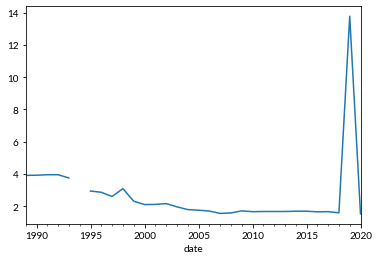

In [7]:
data.plot()